In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [ ]:
cov2_df = pd.read_csv('COV2_data.csv')
sars_df = pd.read_csv('SARS_data.csv')

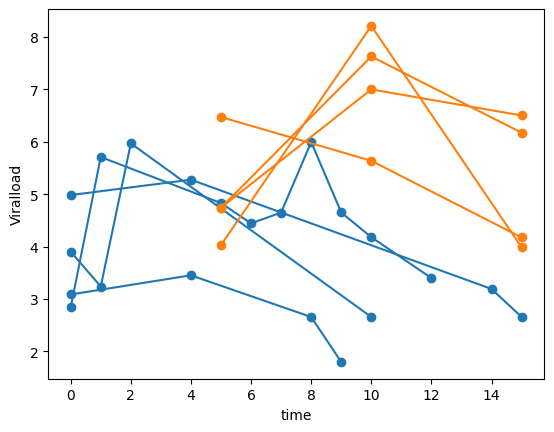

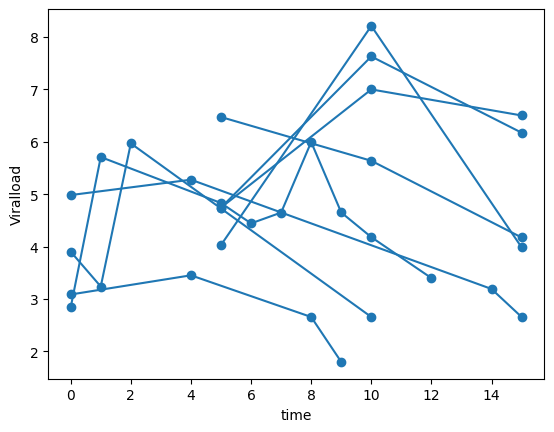

In [ ]:
#설명을 위한 그림2,1
#그림2: 색 별로 구분이 되는 COV2_data와 SARS_data (원하는 결과)
#그림1: 구분이 되지 않는 COV2_data와 SARS_data (초기)
disease_time,disease_viralload =[],[]

###그림2########################################################################
for i in set(cov2_df['ID']):
  a = cov2_df[cov2_df['ID'] == i]
  disease_time.append(list(a['time']))
  disease_viralload.append(list(a['Viralload']))
  plt.plot(list(a['time']), list(a['Viralload']),'o-', c='C0')

for i in set(sars_df['ID']):
  a = sars_df[sars_df['ID'] == i]
  disease_time.append(list(a['time']))
  disease_viralload.append(list(a['Viralload']))
  plt.plot(list(a['time']), list(a['Viralload']),'o-', c='C1')
plt.ylabel('Viralload')
plt.xlabel('time')
plt.show()
###그림1########################################################################
for i in range(len(disease_time)):
  plt.plot(disease_time[i], disease_viralload[i], 'o-', c='C0')
plt.ylabel('Viralload')
plt.xlabel('time')
plt.show()
################################################################################

In [ ]:
for i in range(len(disease_time)):

  print(f'===== data{i+1} =====')
  print('time : ', disease_time[i])
  print('viralload : ', disease_viralload[i], end='\n\n')

===== data1 =====
time :  [0, 4, 8, 9]
viralload :  [3.087006548, 3.453152587, 2.657609682, 1.8]

===== data2 =====
time :  [0, 4, 14, 15]
viralload :  [4.984663663, 5.278315713, 3.192278037, 2.657609682]

===== data3 =====
time :  [0, 1, 2, 10]
viralload :  [3.904245743, 3.239373177, 5.970891303, 2.657609682]

===== data4 =====
time :  [0, 1, 5, 6, 7, 8, 9, 10, 12]
viralload :  [2.841365438, 5.710482881, 4.832454524, 4.444454703, 4.650772279, 5.996704008, 4.65222738, 4.181275979, 3.4]

===== data5 =====
time :  [5, 10, 15]
viralload :  [4.745, 7.63, 6.175]

===== data6 =====
time :  [5, 10, 15]
viralload :  [6.474, 5.639, 4.175]

===== data7 =====
time :  [5, 10, 15]
viralload :  [4.745, 7.001, 6.504]

===== data8 =====
time :  [5, 10, 15]
viralload :  [4.031, 8.213, 3.987]



In [ ]:
def make_avg_data(idx_list):

  max_time=0
  for idx in idx_list:
    max_time = max(disease_time[idx][-1], max_time)
  n_t = [i for i in range(max_time+1)]

  data_array_list=[]
  for idx in idx_list:
    data_array=[]
    for i in range(max_time+1):
      if i in disease_time[idx]:
        data_array.append(disease_viralload[idx][disease_time[idx].index(i)])
      else:
        data_array.append(float('nan'))
    data_array_list.append(np.array(data_array))

    n_v = np.nanmean(np.vstack(data_array_list),axis=0)

  return n_v, n_t

In [ ]:
###미분방정식###################################################################
def dT(beta, T, V):
  return -beta*T*V
def dV(r,T,V,delta):
  return r*T*V - delta*V

###fitting 함수###############################################################
def system(t, y, params):
    V, T = y
    beta, r, delta = params

    dV_dt = dV(r,T,V,delta)
    dT_dt = dT(beta, T, V)

    return [dV_dt, dT_dt]

def simulate(params, initial_conditions, t_span, t_eval):
    sol = solve_ivp(fun=lambda t, y: system(t, y, params),
                    t_span=t_span, y0=initial_conditions, t_eval=t_eval,
                    method='RK45', rtol=1e-6, atol=1e-8)
    results = pd.DataFrame({'time': sol.t, 'V': sol.y[0]})

    return results

def cost_function(variables, real_data, t_span, t_eval, iteration_log):
    params = variables[:3]
    initial_conditions = variables[3:]

    sim_result = simulate(params, initial_conditions, t_span, t_eval)

    sim_V = np.interp(real_data['time'], sim_result['time'], sim_result['V'])

    # 실제 데이터와 시뮬레이션 결과 간의 오차 제곱합 계산(SSR)
    valid_V_indices = ~np.isnan(real_data['V'])
    SSR = np.sum((real_data['V'][valid_V_indices] - sim_V[valid_V_indices]) ** 2)

    # 최적화 과정을 기록
    iteration_log.append(SSR)
    # print(f"Iteration {len(iteration_log)}: SSR = {SSR}")

    return SSR

def cost_function_list(variables, real_data_dix_list, t_span, t_eval, iteration_log):
    params = variables[:3]
    initial_conditions = variables[3:]

    sim_result = simulate(params, initial_conditions, t_span, t_eval)

    SSR=0
    for idx in real_data_dix_list:
        n_v, n_t = make_avg_data([idx])
        real_data = pd.DataFrame({'time': n_t, 'V': n_v})
        sim_V = np.interp(real_data['time'], sim_result['time'], sim_result['V'])
    # 실제 데이터와 시뮬레이션 결과 간의 오차 제곱합 계산(SSR)
        valid_V_indices = ~np.isnan(real_data['V'])
        SSR += (np.sum((real_data['V'][valid_V_indices] - sim_V[valid_V_indices]) ** 2))/len(real_data_dix_list)

    # 최적화 과정을 기록
    iteration_log.append(SSR)
    # print(f"Iteration {len(iteration_log)}: SSR = {SSR}")

    return SSR

In [ ]:
#무작위로 선택된 서로 다른 두 데이터에 fitting된 두 파라미터로부터 시작한다.
start_sample = list(range(len(disease_time)))
rd.shuffle(start_sample)
print(start_sample)

[4, 0, 1, 2, 6, 7, 3, 5]


In [ ]:
start_sample = [i for i in range(8)]

In [ ]:
n_v, n_t = make_avg_data(start_sample[:4])
# real_data = pd.DataFrame({'time': n_t, 'V': n_v})
real_data_dix_list = start_sample[:4]

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_conditions_guess = [0.1, 3]  # V_0, T_0
params_guess = [0.1, 1.0, 1.0]  # beta_,r,delta
initial_guess = params_guess + initial_conditions_guess
bounds = [(0, None) for i in range(len(initial_guess))]

t_span = [0, 15]  # 시뮬레이션할 시간 범위
t_eval = np.linspace(t_span[0], t_span[1], n_t[-1]*100)  # 계산할 시간 포인트

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(real_data_dix_list, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [ 6.73120858 19.89485999  0.03862438]
최적화된 초기 조건: [3.70431777 0.54281448]


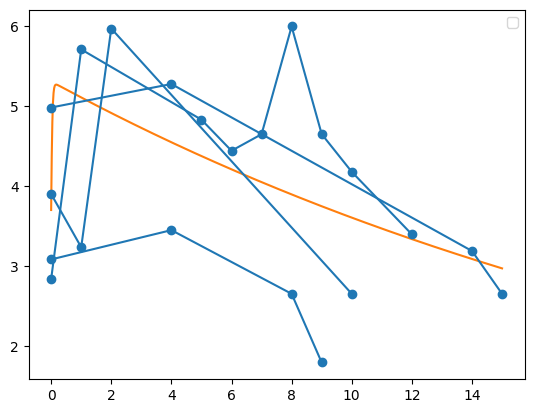

In [ ]:
optimized_params_1, optimized_initial_conditions_1 = optimized_params, optimized_initial_conditions
t_1,v_1 = optimized_result['time'], optimized_result['V']

plt.plot(t_1,v_1,c = 'C1')
for idx in start_sample[:4]:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
# plt.scatter(n_t,n_v, c = 'C2', s=60)

plt.legend()

In [ ]:
n_v, n_t = make_avg_data(start_sample[4:])
# real_data = pd.DataFrame({'time': n_t, 'V': n_v})
real_data_dix_list = start_sample[4:]

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_conditions_guess = [0.1, 3]  # V_0, T_0
params_guess = [0.1, 1.0, 1.0]  # beta_,r,delta
initial_guess = params_guess + initial_conditions_guess
bounds = [(0, None) for i in range(len(initial_guess))]

t_span = [0, 15]  # 시뮬레이션할 시간 범위
t_eval = np.linspace(t_span[0], t_span[1], n_t[-1]*100)  # 계산할 시간 포인트

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(real_data_dix_list, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [0.11471195 0.08696607 0.06458793]
최적화된 초기 조건: [ 0.05269094 13.07516599]


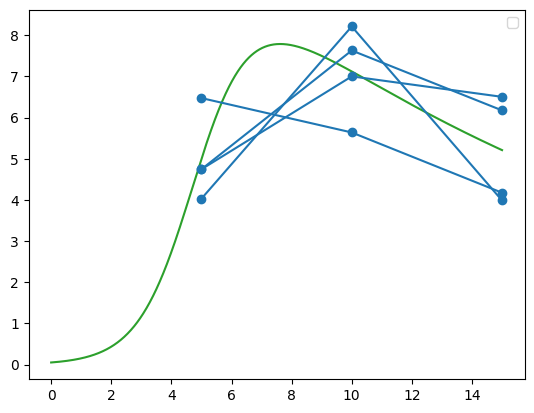

In [ ]:
optimized_params_2, optimized_initial_conditions_2 = optimized_params, optimized_initial_conditions
t_2,v_2 = optimized_result['time'], optimized_result['V']

plt.plot(t_2,v_2,c = 'C2')
for idx in start_sample[4:]:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
# plt.scatter(n_t,n_v, c = 'C2', s=60)
plt.legend()

plt.legend()

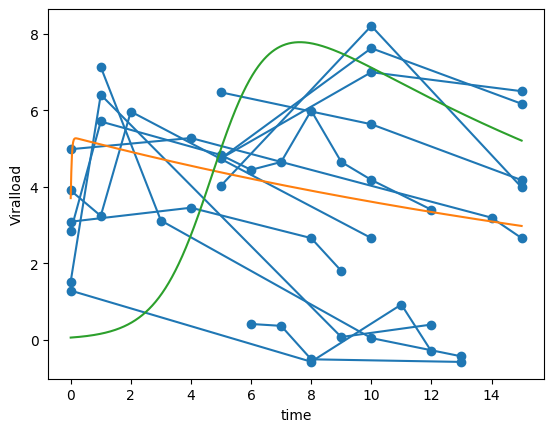

In [ ]:
for i in range(len(disease_time)):
  plt.plot(disease_time[i], disease_viralload[i], 'o-', c='C0')
plt.ylabel('Viralload')
plt.xlabel('time')

plt.plot(t_1,v_1,c='C1')
plt.plot(t_2,v_2,c='C2')
plt.show()

In [ ]:
def print_model_error(params, initial_conditions, real_data, t_span, t_eval,name):
    # 시뮬레이션 실행
    sim_result = simulate(params, initial_conditions, t_span, t_eval)

    # 실제 데이터의 시간에 시뮬레이션 결과 보간
    sim_V = np.interp(real_data['time'], sim_result['time'], sim_result['V'])

    # 유효한 V 값만 비교
    valid_V_indices = ~np.isnan(real_data['V'])

    # 오차 제곱합 계산
    SSR = np.sum((real_data['V'][valid_V_indices] - sim_V[valid_V_indices]) ** 2)

    print(f"{name}의 오차 제곱합 (SSR): {SSR}")

    return SSR

In [ ]:
a_dis=[]
b_dis=[]
for idx in range(len(disease_time)):
  n_v, n_t = make_avg_data([idx])
  real_data = pd.DataFrame({'time': n_t, 'V': n_v})

  print(f'===== data{idx+1} =====')
  a = print_model_error(optimized_params_1, optimized_initial_conditions_1, real_data, t_span, t_eval, 'params1')
  b = print_model_error(optimized_params_2, optimized_initial_conditions_2, real_data, t_span, t_eval, 'params2')
  print('')
  if a < b:
    a_dis.append(idx)
  else:
    b_dis.append(idx)

<ipython-input-350-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


===== data1 =====
params1의 오차 제곱합 (SSR): 7.467116925183724
params2의 오차 제곱합 (SSR): 59.539404223628935

===== data2 =====
params1의 오차 제곱합 (SSR): 11.627952968883694
params2의 오차 제곱합 (SSR): 65.21765519545697

===== data3 =====
params1의 오차 제곱합 (SSR): 8.544849081048433
params2의 오차 제곱합 (SSR): 27.447582199650352

===== data4 =====
params1의 오차 제곱합 (SSR): 5.450609337453604
params2의 오차 제곱합 (SSR): 69.66101041154707

===== data5 =====
params1의 오차 제곱합 (SSR): 14.362965791078203
params2의 오차 제곱합 (SSR): 3.5247159509776456

===== data6 =====
params1의 오차 제곱합 (SSR): 12.834650904791868
params2의 오차 제곱합 (SSR): 5.609393324425076

===== data7 =====
params1의 오차 제곱합 (SSR): 10.492970320327432
params2의 오차 제곱합 (SSR): 6.67113559634925

===== data8 =====
params1의 오차 제곱합 (SSR): 5.395021587234333
params2의 오차 제곱합 (SSR): 2.8510082082753954



Text(0.5, 0, 'time')

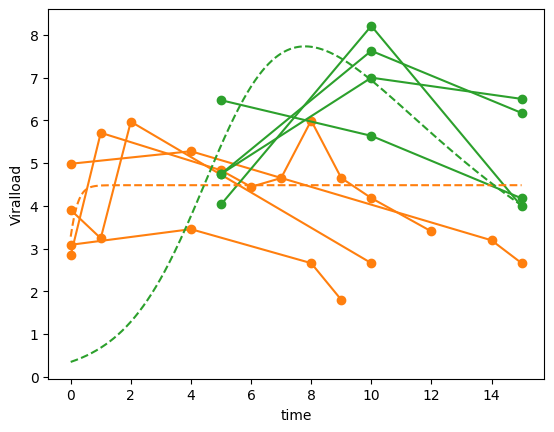

In [ ]:
for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C1')

for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C2')

plt.plot(t_1,v_1,c='C1',linestyle='--')
plt.plot(t_2,v_2,c='C2',linestyle='--')
plt.ylabel('Viralload')
plt.xlabel('time')

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_1) + list(optimized_initial_conditions_1)

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(a_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)

<ipython-input-350-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


Iteration 1: SSR = 8.272632078142363
Iteration 2: SSR = 8.073518143269657
Iteration 3: SSR = 8.5117395914045
Iteration 4: SSR = 8.217228865425822
Iteration 5: SSR = 8.88212668672623
Iteration 6: SSR = 8.511739586400513
Iteration 7: SSR = 7.986013507545095
Iteration 8: SSR = 7.919933830149484
Iteration 9: SSR = 7.851630840985694
Iteration 10: SSR = 7.722413114053523
Iteration 11: SSR = 7.718060415946037
Iteration 12: SSR = 7.815270618704972
Iteration 13: SSR = 7.774831842071346
Iteration 14: SSR = 8.010578391652476
Iteration 15: SSR = 8.505734370635729
Iteration 16: SSR = 7.805839165003703
Iteration 17: SSR = 8.053789732096481
Iteration 18: SSR = 7.826103292449383
Iteration 19: SSR = 7.599256409849465
Iteration 20: SSR = 7.482873789179704
Iteration 21: SSR = 7.6493501815814735
Iteration 22: SSR = 7.584278862611619
Iteration 23: SSR = 7.520736805681068
Iteration 24: SSR = 7.434323595664783
Iteration 25: SSR = 7.34512605828274
Iteration 26: SSR = 7.336622411548851
Iteration 27: SSR = 7.28

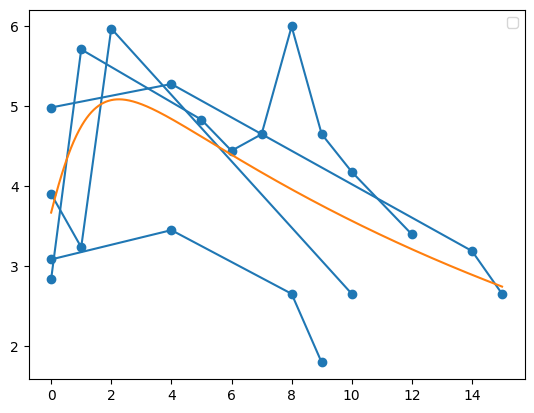

In [ ]:
optimized_params_1, optimized_initial_conditions_1 = optimized_params, optimized_initial_conditions
t_1,v_1 = optimized_result['time'], optimized_result['V']

for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_1,v_1, c='C1')
plt.legend()

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_2) + list(optimized_initial_conditions_2)

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(b_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)

<ipython-input-350-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


Iteration 1: SSR = 4.664063270006841
Iteration 2: SSR = 5.415917958940519
Iteration 3: SSR = 5.508647377633624
Iteration 4: SSR = 5.225520406873211
Iteration 5: SSR = 4.8834677248598375
Iteration 6: SSR = 5.50864737666879
Iteration 7: SSR = 5.447177700063347
Iteration 8: SSR = 6.38851554709965
Iteration 9: SSR = 5.03608677438506
Iteration 10: SSR = 5.248738040384927
Iteration 11: SSR = 4.968492454582181
Iteration 12: SSR = 4.813739829231895
Iteration 13: SSR = 4.6711244440693385
Iteration 14: SSR = 4.366409408940022
Iteration 15: SSR = 4.096927142539919
Iteration 16: SSR = 4.705236953981578
Iteration 17: SSR = 4.148984569443624
Iteration 18: SSR = 4.076353384296188
Iteration 19: SSR = 4.021853533462158
Iteration 20: SSR = 4.704737355900531
Iteration 21: SSR = 4.323151236744354
Iteration 22: SSR = 3.888139220852412
Iteration 23: SSR = 3.9081591370879125
Iteration 24: SSR = 3.689235695794311
Iteration 25: SSR = 3.877287230156238
Iteration 26: SSR = 3.7312914234171966
Iteration 27: SSR = 

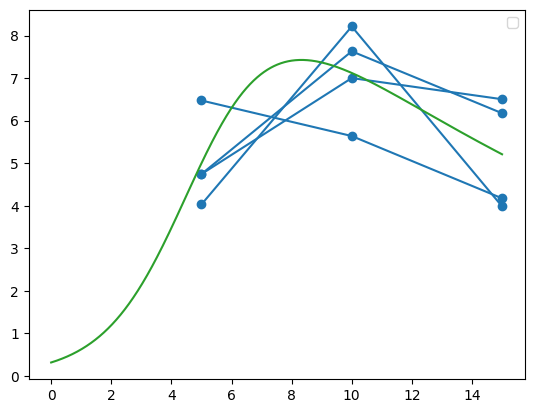

In [ ]:
optimized_params_2, optimized_initial_conditions_2 = optimized_params, optimized_initial_conditions
t_2,v_2 = optimized_result['time'], optimized_result['V']

for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_2,v_2,c='C2')
plt.legend()

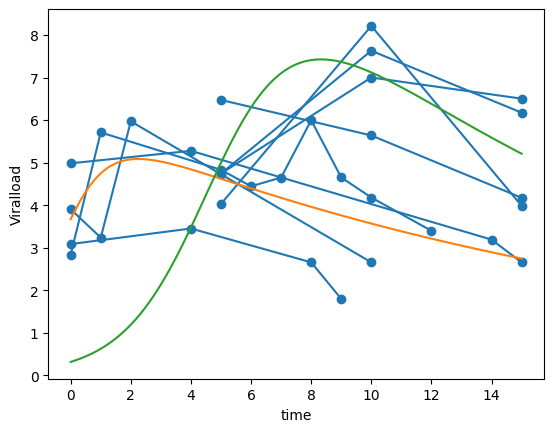

In [ ]:
for i in range(len(disease_time)):
  plt.plot(disease_time[i], disease_viralload[i], 'o-', c='C0')
plt.ylabel('Viralload')
plt.xlabel('time')

plt.plot(t_1,v_1,c='C1')
plt.plot(t_2,v_2,c='C2')
plt.show()

In [ ]:
a_dis=[]
b_dis=[]
for idx in range(len(disease_time)):
  n_v, n_t = make_avg_data([idx])
  real_data = pd.DataFrame({'time': n_t, 'V': n_v})

  print('--------')
  a = print_model_error(optimized_params_1, optimized_initial_conditions_1, real_data, t_span, t_eval, 'params1')
  b = print_model_error(optimized_params_2, optimized_initial_conditions_2, real_data, t_span, t_eval, 'params2')

  if a < b:
    a_dis.append(idx)
  else:
    b_dis.append(idx)

<ipython-input-350-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


--------
params1의 오차 제곱합 (SSR): 3.9611180182401706
params2의 오차 제곱합 (SSR): 62.43080575958017
--------
params1의 오차 제곱합 (SSR): 7.81898882746043
params2의 오차 제곱합 (SSR): 61.246279176237614
--------
params1의 오차 제곱합 (SSR): 2.0098162403011113
params2의 오차 제곱합 (SSR): 37.269708665532136
--------
params1의 오차 제곱합 (SSR): 7.232194870888415
params2의 오차 제곱합 (SSR): 68.5791214874513
--------
params1의 오차 제곱합 (SSR): 23.447365770747282
params2의 오차 제곱합 (SSR): 3.625895755234102
--------
params1의 오차 제곱합 (SSR): 28.25162564540488
params2의 오차 제곱합 (SSR): 1.254463150451957
--------
params1의 오차 제곱합 (SSR): 25.902465025277728
params2의 오차 제곱합 (SSR): 1.7525187854834747
--------
params1의 오차 제곱합 (SSR): 9.75586014864196
params2의 오차 제곱합 (SSR): 5.443686559052618


Text(0.5, 0, 'time')

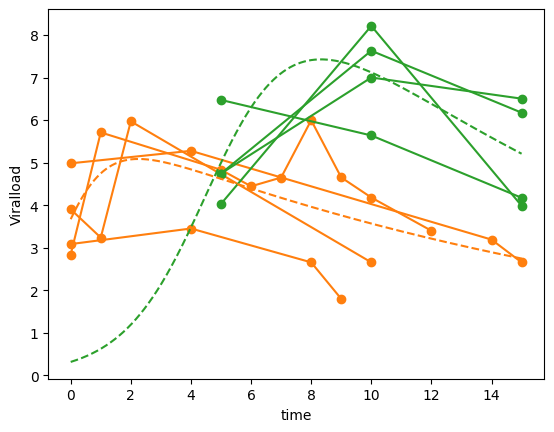

In [ ]:
for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C1')

for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C2')

plt.plot(t_1,v_1,c='C1', linestyle='--')
plt.plot(t_2,v_2,c='C2', linestyle='--')

plt.ylabel('Viralload')
plt.xlabel('time')

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_1) + list(optimized_initial_conditions_1)

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(a_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_1, optimized_initial_conditions_1 = optimized_params, optimized_initial_conditions
t_1,v_1 = optimized_result['time'], optimized_result['V']

for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_1,v_1,'C1')
plt.legend()

<ipython-input-350-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


Iteration 1: SSR = 5.255529489222532
Iteration 2: SSR = 5.276515369077645
Iteration 3: SSR = 5.280637065209902
Iteration 4: SSR = 5.277567654964997
Iteration 5: SSR = 5.369316014732617
Iteration 6: SSR = 5.280637065236657
Iteration 7: SSR = 5.35790302391609
Iteration 8: SSR = 5.280121565285935
Iteration 9: SSR = 5.323584512094543
Iteration 10: SSR = 5.25871614757878
Iteration 11: SSR = 5.34528690556243
Iteration 12: SSR = 5.25771781785746
Iteration 13: SSR = 5.268040783606223
Iteration 14: SSR = 5.276684292985131
Iteration 15: SSR = 5.260954033398237
Iteration 16: SSR = 5.315396605947465
Iteration 17: SSR = 5.258714705374339
Iteration 18: SSR = 5.263171048915728
Iteration 19: SSR = 5.257290762667916
Iteration 20: SSR = 5.25972047413926
Iteration 21: SSR = 5.256655439701666
Iteration 22: SSR = 5.2596568689228596
Iteration 23: SSR = 5.2563903731896655
Iteration 24: SSR = 5.264038697925219
Iteration 25: SSR = 5.256132461633083
Iteration 26: SSR = 5.258157261250797
Iteration 27: SSR = 5.25

KeyboardInterrupt: 

<ipython-input-5-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


Iteration 1: SSR = 6.081723362255115
Iteration 2: SSR = 6.097839296884984
Iteration 3: SSR = 6.099447242412937
Iteration 4: SSR = 6.092568877002827
Iteration 5: SSR = 6.196611668106444
Iteration 6: SSR = 6.099447804818592
Iteration 7: SSR = 6.186396039931673
Iteration 8: SSR = 6.106893423214128
Iteration 9: SSR = 6.111742217878492
Iteration 10: SSR = 6.087576518307818
Iteration 11: SSR = 6.12003094394519
Iteration 12: SSR = 6.084417549237113
Iteration 13: SSR = 6.132850811649072
Iteration 14: SSR = 6.083645917604286
Iteration 15: SSR = 6.097329273699314
Iteration 16: SSR = 6.08525019707573
Iteration 17: SSR = 6.09877568049162
Iteration 18: SSR = 6.084167768669751
Iteration 19: SSR = 6.094236092497255
Iteration 20: SSR = 6.0829139989941154
Iteration 21: SSR = 6.082848529500965
Iteration 22: SSR = 6.087067181084088
Iteration 23: SSR = 6.082267716039441
Iteration 24: SSR = 6.083833389593508
Iteration 25: SSR = 6.082266917233136
Iteration 26: SSR = 6.084183574262244
Iteration 27: SSR = 6.0

Iteration 505: SSR = 6.081723356594985
Iteration 506: SSR = 6.081723356594988
Iteration 507: SSR = 6.081723356594987
최적화된 파라미터: [5.32324762e+00 3.37146721e+02 3.11877816e-02]
최적화된 초기 조건: [3.70432029 0.02629054]


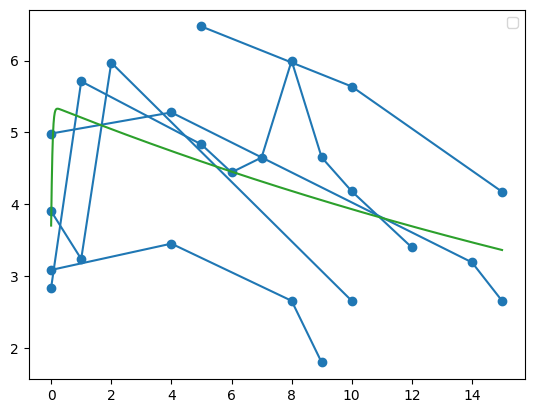

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_2) + list(optimized_initial_conditions_2)

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(b_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_2, optimized_initial_conditions_2 = optimized_params, optimized_initial_conditions
t_2,v_2 = optimized_result['time'], optimized_result['V']

for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_2,v_2,'C2')
plt.legend()

<ipython-input-5-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


--------
params1의 오차 제곱합 (SSR): 43.90614061634149
params2의 오차 제곱합 (SSR): 6.389253316072203
--------
params1의 오차 제곱합 (SSR): 49.6124126321881
params2의 오차 제곱합 (SSR): 9.469536654276135
--------
params1의 오차 제곱합 (SSR): 32.20823663058336
params2의 오차 제곱합 (SSR): 2.5049707063017217
--------
params1의 오차 제곱합 (SSR): 54.15221587455079
params2의 오차 제곱합 (SSR): 4.948765637639056
--------
params1의 오차 제곱합 (SSR): 3.0442480917626056
params2의 오차 제곱합 (SSR): 19.030172520290925
--------
params1의 오차 제곱합 (SSR): 0.44086592229785854
params2의 오차 제곱합 (SSR): 21.592794646509912
--------
params1의 오차 제곱합 (SSR): 1.3331993192732998
params2의 오차 제곱합 (SSR): 19.294333139104765
--------
params1의 오차 제곱합 (SSR): 9.677669969768491
params2의 오차 제곱합 (SSR): 7.09609046868581


Text(0.5, 0, 'time')

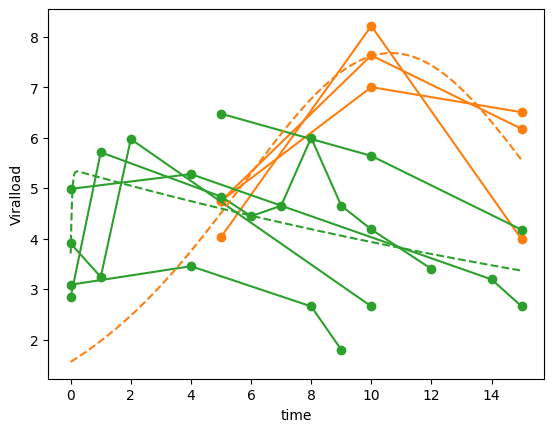

In [ ]:
a_dis=[]
b_dis=[]
for idx in range(len(disease_time)):
  n_v, n_t = make_avg_data([idx])
  real_data = pd.DataFrame({'time': n_t, 'V': n_v})

  print('--------')
  a = print_model_error(optimized_params_1, optimized_initial_conditions_1, real_data, t_span, t_eval, 'params1')
  b = print_model_error(optimized_params_2, optimized_initial_conditions_2, real_data, t_span, t_eval, 'params2')

  if a < b:
    a_dis.append(idx)
  else:
    b_dis.append(idx)

for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C1')

for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C2')

plt.plot(t_1,v_1,c='C1', linestyle='--')
plt.plot(t_2,v_2,c='C2', linestyle='--')

plt.ylabel('Viralload')
plt.xlabel('time')

## 2.

In [ ]:
s_p1,s_i1 = optimized_params_1, optimized_initial_conditions_1
s_p2,s_i2 = optimized_params_2, optimized_initial_conditions_2
s_t1,s_v1 = t_1,v_1
s_t2,s_v2 = t_2,v_2

In [ ]:
optimized_params_1, optimized_initial_conditions_1 =s_p1,s_i1
optimized_params_2, optimized_initial_conditions_2 =s_p2,s_i2
t_1,v_1=s_t1,s_v1
t_2,v_2=s_t2,s_v2

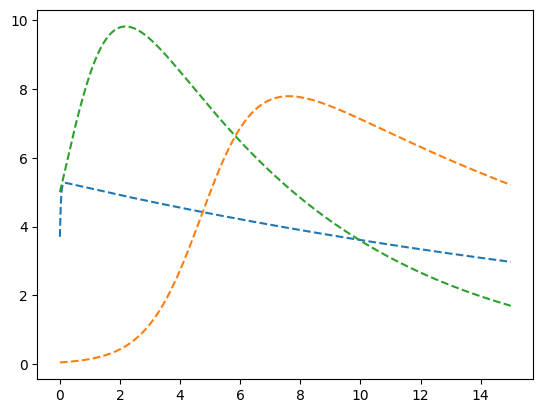

In [ ]:
sample_params_3, sample_initial_conditions_3 = [0.1, 0.0015, 0.15], [  5 ,600]
sample_result = simulate(sample_params_3, sample_initial_conditions_3, t_span, t_eval)
t_3,v_3 = sample_result['time'], sample_result['V']

plt.plot(t_1,v_1,c='C0', linestyle='--')
plt.plot(t_2,v_2,c='C1', linestyle='--')
plt.plot(t_3,v_3,c='C2', linestyle='--')

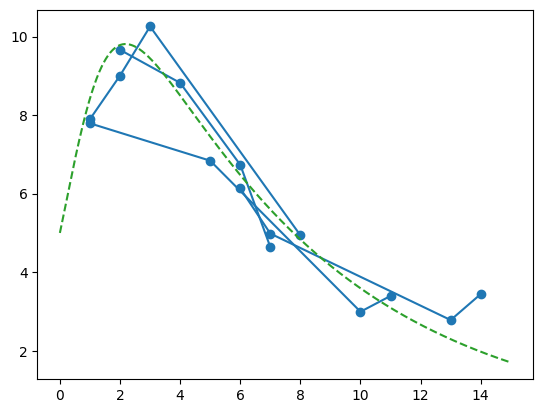

In [ ]:
t_l_list, v_l_list=[],[]
for i in range(4):
  time_sample = rd.sample(list(range(15)),k=4)
  t_l,v_l=[],[]
  for i in sorted(time_sample):
    t = i
    v = np.random.normal(v_3[i*100], 0.5)

    t_l.append(t)
    v_l.append(v)

  t_l_list.append(t_l)
  v_l_list.append(v_l)

for idx in range(len(t_l_list)):
  plt.plot(t_l_list[idx], v_l_list[idx], 'o-', c='C0')

plt.plot(t_3,v_3,c='C2', linestyle='--')

In [ ]:
for idx in range(len(t_l_list)):
  disease_time.append(t_l_list[idx])
  disease_viralload.append(v_l_list[idx])

Text(0.5, 0, 'time')

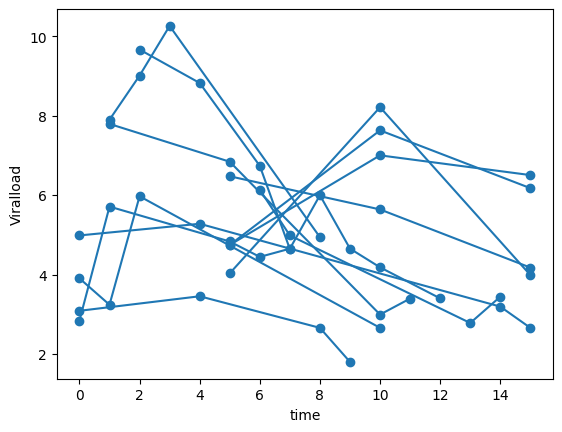

In [ ]:
for i in range(len(disease_time)):
  plt.plot(disease_time[i], disease_viralload[i], 'o-', c='C0')
plt.ylabel('Viralload')
plt.xlabel('time')

In [ ]:
#무작위로 선택된 서로 다른 두 데이터에 fitting된 두 파라미터로부터 시작한다.
start_sample = list(range(len(disease_time)))
rd.shuffle(start_sample)
print(start_sample)

[3, 6, 0, 8, 10, 7, 4, 2, 5, 1, 9, 11]


In [ ]:
n_v, n_t = make_avg_data(start_sample[:4])
# real_data = pd.DataFrame({'time': n_t, 'V': n_v})
real_data_dix_list = start_sample[:4]

# 파라미터와 초기 조건, boundary 설정
initial_conditions_guess = [0.1, 3]  # V_0, T_0
params_guess = [0.1, 1.0, 1.0]  # beta_,r,delta
initial_guess = params_guess + initial_conditions_guess
bounds = [(-10, None) for i in range(len(initial_guess))]

t_span = [0, 15]  # 시뮬레이션할 시간 범위
t_eval = np.linspace(t_span[0], t_span[1], n_t[-1]*100)  # 계산할 시간 포인트

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(real_data_dix_list, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [2.08809271 0.22374171 0.01398153]
최적화된 초기 조건: [ 2.96434047 19.60456291]


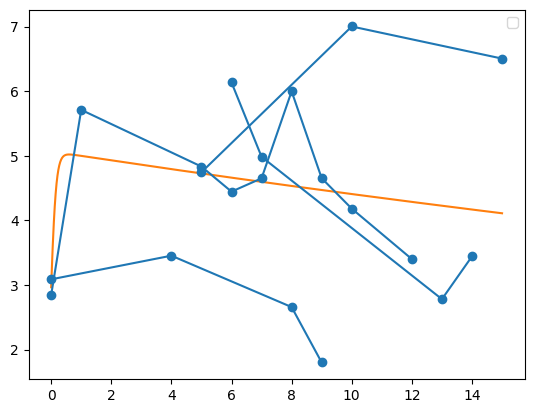

In [ ]:
optimized_params_1, optimized_initial_conditions_1 = optimized_params, optimized_initial_conditions
t_1,v_1 = optimized_result['time'], optimized_result['V']

plt.plot(t_1,v_1,c = 'C1')
for idx in start_sample[:4]:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
# plt.scatter(n_t,n_v, c = 'C2', s=60)
plt.legend()

In [ ]:
n_v, n_t = make_avg_data(start_sample[4:8])
# real_data = pd.DataFrame({'time': n_t, 'V': n_v})
real_data_dix_list = start_sample[4:8]

# 파라미터와 초기 조건, boundary 설정
initial_conditions_guess = [0.1, 3]  # V_0, T_0
params_guess = [0.1, 1.0, 1.0]  # beta_,r,delta
initial_guess = params_guess + initial_conditions_guess
bounds = [(-10, None) for i in range(len(initial_guess))]

t_span = [0, 15]  # 시뮬레이션할 시간 범위
t_eval = np.linspace(t_span[0], t_span[1], n_t[-1]*100)  # 계산할 시간 포인트

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(real_data_dix_list, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [0.22099072 0.23269088 0.03136052]
최적화된 초기 조건: [3.54436691 3.88047651]


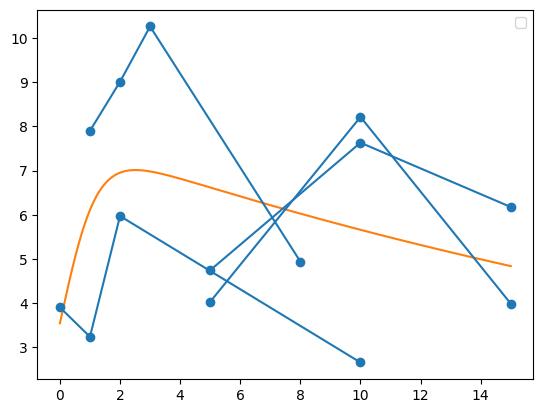

In [ ]:
optimized_params_2, optimized_initial_conditions_2 = optimized_params, optimized_initial_conditions
t_2,v_2 = optimized_result['time'], optimized_result['V']

plt.plot(t_2,v_2,c = 'C1')
for idx in start_sample[4:8]:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
# plt.scatter(n_t,n_v, c = 'C2', s=60)
plt.legend()

In [ ]:
n_v, n_t = make_avg_data(start_sample[8:])
# real_data = pd.DataFrame({'time': n_t, 'V': n_v})
real_data_dix_list = start_sample[8:]

# 파라미터와 초기 조건, boundary 설정
initial_conditions_guess = [0.1, 3]  # V_0, T_0
params_guess = [0.1, 1.0, 1.0]  # beta_,r,delta
initial_guess = params_guess + initial_conditions_guess
bounds = [(-10, None) for i in range(len(initial_guess))]

t_span = [0, 15]  # 시뮬레이션할 시간 범위
t_eval = np.linspace(t_span[0], t_span[1], n_t[-1]*100)  # 계산할 시간 포인트

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(real_data_dix_list, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [0.20451171 0.00939145 0.08726763]
최적화된 초기 조건: [  4.89636988 113.01456364]


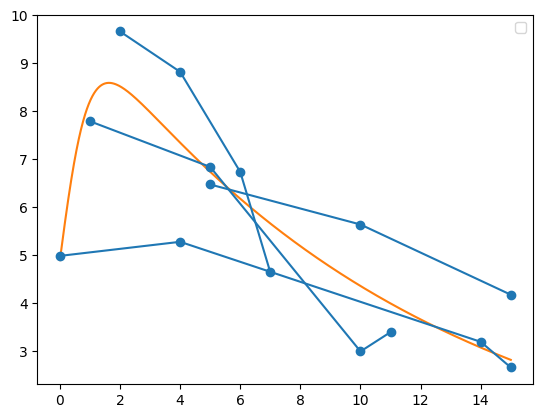

In [ ]:
optimized_params_3, optimized_initial_conditions_3 = optimized_params, optimized_initial_conditions
t_3,v_3 = optimized_result['time'], optimized_result['V']

plt.plot(t_3,v_3,c = 'C1')
for idx in start_sample[8:]:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
# plt.scatter(n_t,n_v, c = 'C2', s=60)
plt.legend()

In [ ]:
a_dis=[]
b_dis=[]
c_dis=[]
for idx in range(len(disease_time)):
  n_v, n_t = make_avg_data([idx])
  real_data = pd.DataFrame({'time': n_t, 'V': n_v})

  print(f'===== data{idx+1} =====')
  a = print_model_error(optimized_params_1, optimized_initial_conditions_1, real_data, t_span, t_eval, 'params1')
  b = print_model_error(optimized_params_2, optimized_initial_conditions_2, real_data, t_span, t_eval, 'params2')
  c = print_model_error(optimized_params_3, optimized_initial_conditions_3, real_data, t_span, t_eval, 'params3')
  print('')
  if a == min(a,b,c):
    a_dis.append(idx)
  elif b == min(a,b,c):
    b_dis.append(idx)
  else:
    c_dis.append(idx)

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


===== data1 =====
params1의 오차 제곱합 (SSR): 12.449223308110628
params2의 오차 제곱합 (SSR): 39.17845907097622
params3의 오차 제곱합 (SSR): 33.554611933478775

===== data2 =====
params1의 오차 제곱합 (SSR): 7.376874150324018
params2의 오차 제곱합 (SSR): 12.431965898583243
params3의 오차 제곱합 (SSR): 4.32143937291283

===== data3 =====
params1의 오차 제곱합 (SSR): 8.123709364031422
params2의 오차 제곱합 (SSR): 18.33015736351962
params3의 오차 제곱합 (SSR): 35.09164409387592

===== data4 =====
params1의 오차 제곱합 (SSR): 3.597340418448258
params2의 오차 제곱합 (SSR): 17.434717384276894
params3의 오차 제곱합 (SSR): 18.889110322263786

===== data5 =====
params1의 오차 제곱합 (SSR): 14.652196513674664
params2의 오차 제곱합 (SSR): 9.174530048596973
params3의 오차 제곱합 (SSR): 25.966408972933245

===== data6 =====
params1의 오차 제곱합 (SSR): 4.575762397375706
params2의 오차 제곱합 (SSR): 0.4602383599687906
params3의 오차 제곱합 (SSR): 3.5595661673443146

===== data7 =====
params1의 오차 제곱합 (SSR): 12.46083513916983
params2의 오차 제곱합 (SSR): 8.078991029886355
params3의 오차 제곱합 (SSR): 24.56275910833388

Text(0.5, 0, 'time')

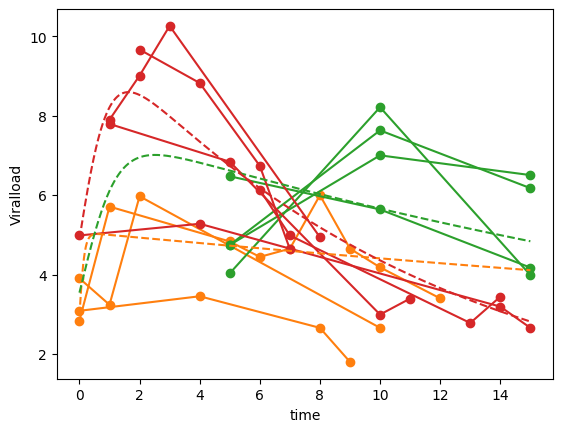

In [ ]:
for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C1')

for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C2')

for idx in c_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C3')

plt.plot(t_1,v_1,c='C1',linestyle='--')
plt.plot(t_2,v_2,c='C2',linestyle='--')
plt.plot(t_3,v_3,c='C3',linestyle='--')
plt.ylabel('Viralload')
plt.xlabel('time')

In [ ]:
##############################################################3

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [0.26565586 0.01610606 0.05073013]
최적화된 초기 조건: [ 3.24474431 41.33580785]


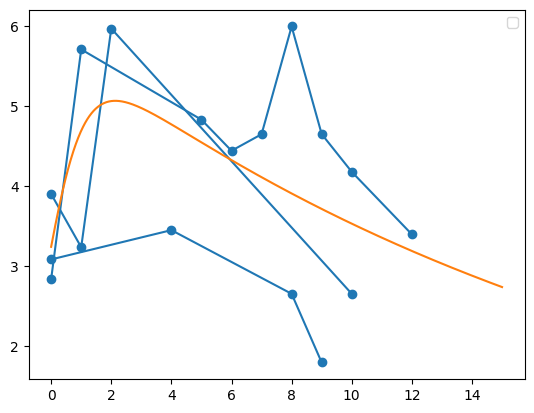

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_1) + [0.1, 3]

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(a_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_1, optimized_initial_conditions_1 = optimized_params, optimized_initial_conditions
t_1,v_1 = optimized_result['time'], optimized_result['V']

for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_1,v_1,'C1')
plt.legend()

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [0.09650763 0.07478629 0.06687649]
최적화된 초기 조건: [ 0.1191168  12.97746036]


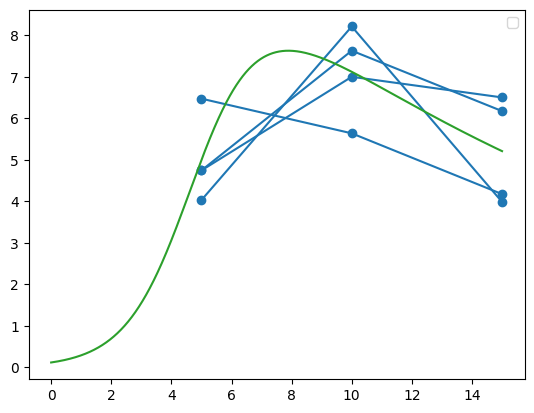

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_2) + [0.1, 3]

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(b_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_2, optimized_initial_conditions_2 = optimized_params, optimized_initial_conditions
t_2,v_2 = optimized_result['time'], optimized_result['V']

for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_2,v_2,'C2')
plt.legend()

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [0.14449077 0.00252133 0.1157871 ]
최적화된 초기 조건: [  4.72230818 393.10688365]


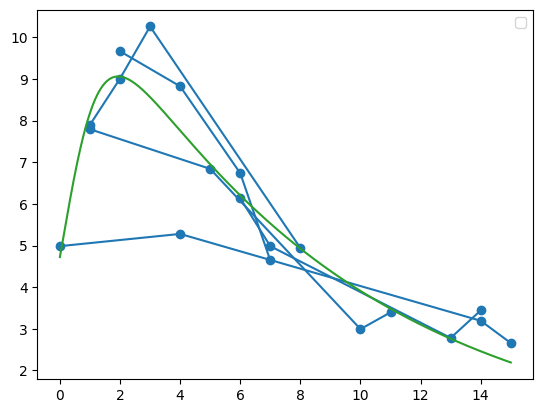

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_3) + [0.1, 3]

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(c_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_3, optimized_initial_conditions_3 = optimized_params, optimized_initial_conditions
t_3,v_3 = optimized_result['time'], optimized_result['V']

for idx in c_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_3,v_3,'C2')
plt.legend()

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


--------
params1의 오차 제곱합 (SSR): 7.0168776349261375
params2의 오차 제곱합 (SSR): 65.60540906556355
params3의 오차 제곱합 (SSR): 33.065673138375345

--------
params1의 오차 제곱합 (SSR): 3.3835047260815356
params2의 오차 제곱합 (SSR): 40.717673784419866
params3의 오차 제곱합 (SSR): 6.979893441607979

--------
params1의 오차 제곱합 (SSR): 4.141163665536304
params2의 오차 제곱합 (SSR): 70.77124234853483
params3의 오차 제곱합 (SSR): 36.186979218661925

--------
params1의 오차 제곱합 (SSR): 7.26311879056229
params2의 오차 제곱합 (SSR): 77.0353192693143
params3의 오차 제곱합 (SSR): 19.368534132252243

--------
params1의 오차 제곱합 (SSR): 28.603389969584
params2의 오차 제곱합 (SSR): 1.2544705168807462
params3의 오차 제곱합 (SSR): 34.57923288819764

--------
params1의 오차 제곱합 (SSR): 10.191284502982766
params2의 오차 제곱합 (SSR): 5.4436828746017465
params3의 오차 제곱합 (SSR): 7.155523419412505

--------
params1의 오차 제곱합 (SSR): 26.21301118033559
params2의 오차 제곱합 (SSR): 1.7525181128738194
params3의 오차 제곱합 (SSR): 33.023241557558585

--------
params1의 오차 제곱합 (SSR): 23.714179626299842
params2의 오차

Text(0.5, 0, 'time')

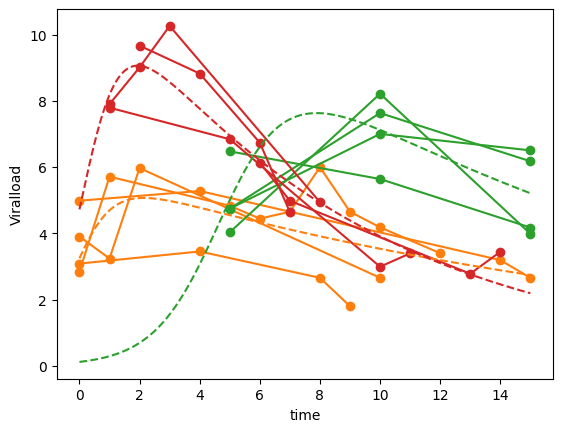

In [ ]:
a_dis=[]
b_dis=[]
c_dis=[]
for idx in range(len(disease_time)):
  n_v, n_t = make_avg_data([idx])
  real_data = pd.DataFrame({'time': n_t, 'V': n_v})

  print('--------')
  a = print_model_error(optimized_params_1, optimized_initial_conditions_1, real_data, t_span, t_eval, 'params1')
  b = print_model_error(optimized_params_2, optimized_initial_conditions_2, real_data, t_span, t_eval, 'params2')
  c = print_model_error(optimized_params_3, optimized_initial_conditions_3, real_data, t_span, t_eval, 'params3')
  print('')
  if a == min(a,b,c):
    a_dis.append(idx)
  elif b == min(a,b,c):
    b_dis.append(idx)
  else:
    c_dis.append(idx)

for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C1')
for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C2')
for idx in c_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C3')

plt.plot(t_1,v_1,c='C1', linestyle='--')
plt.plot(t_2,v_2,c='C2', linestyle='--')
plt.plot(t_3,v_3,c='C3', linestyle='--')

plt.ylabel('Viralload')
plt.xlabel('time')

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [0.20584202 0.00318966 0.05234758]
최적화된 초기 조건: [  3.67194712 143.27575777]


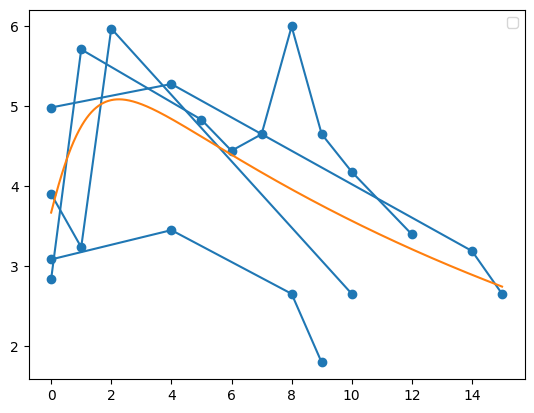

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_1) + [0.1, 3]

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(a_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_1, optimized_initial_conditions_1 = optimized_params, optimized_initial_conditions
t_1,v_1 = optimized_result['time'], optimized_result['V']

for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_1,v_1,'C1')
plt.legend()

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [0.12644555 0.31135421 0.06378652]
최적화된 초기 조건: [0.03055611 4.0040346 ]


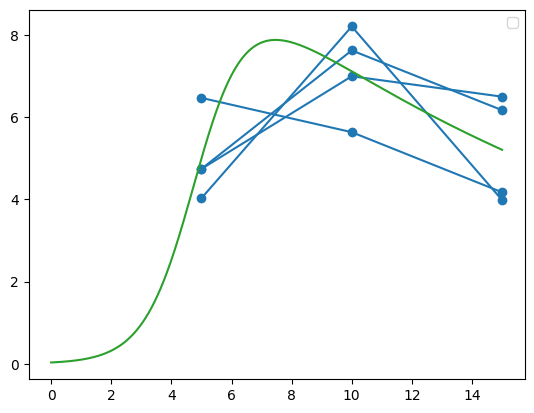

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_2) + [0.1, 3]

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(b_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_2, optimized_initial_conditions_2 = optimized_params, optimized_initial_conditions
t_2,v_2 = optimized_result['time'], optimized_result['V']

for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_2,v_2,'C2')
plt.legend()

In [ ]:
c_dis = [8,9,10,11]

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [0.13689067 0.00176136 0.13764889]
최적화된 초기 조건: [  3.45276797 737.15139277]


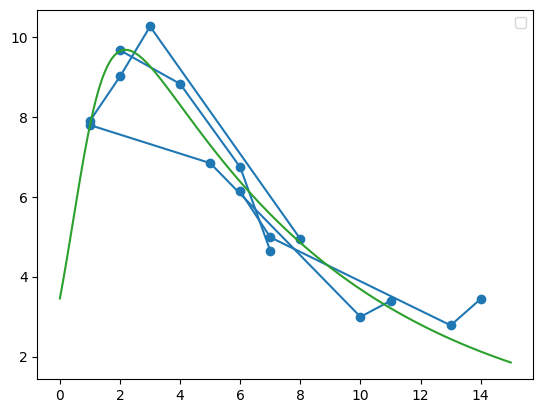

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = [0.1, 0.0015, 0.15] + [  5 ,600]

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(c_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_3, optimized_initial_conditions_3 = optimized_params, optimized_initial_conditions
t_3,v_3 = optimized_result['time'], optimized_result['V']

for idx in c_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_3,v_3,'C2')
plt.legend()

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


--------
params1의 오차 제곱합 (SSR): 7.818970787064428
params2의 오차 제곱합 (SSR): 69.62895278536342
params3의 오차 제곱합 (SSR): 34.23977798774571

--------
params1의 오차 제곱합 (SSR): 2.0098197896437
params2의 오차 제곱합 (SSR): 44.193776203004816
params3의 오차 제곱합 (SSR): 13.227361060667054

--------
params1의 오차 제곱합 (SSR): 3.9611175611256453
params2의 오차 제곱합 (SSR): 76.74529336286002
params3의 오차 제곱합 (SSR): 35.4142130814426

--------
params1의 오차 제곱합 (SSR): 7.232209818824346
params2의 오차 제곱합 (SSR): 84.77530501270873
params3의 오차 제곱합 (SSR): 17.370678566946523

--------
params1의 오차 제곱합 (SSR): 28.251643099999814
params2의 오차 제곱합 (SSR): 1.2544384322377296
params3의 오차 제곱합 (SSR): 40.750152274574006

--------
params1의 오차 제곱합 (SSR): 9.755876832940142
params2의 오차 제곱합 (SSR): 5.4437265391520775
params3의 오차 제곱합 (SSR): 9.892035811546187

--------
params1의 오차 제곱합 (SSR): 25.902481145761648
params2의 오차 제곱합 (SSR): 1.7525071839725153
params3의 오차 제곱합 (SSR): 39.13377596306704

--------
params1의 오차 제곱합 (SSR): 23.447378361009644
params2의 오차

Text(0.5, 0, 'time')

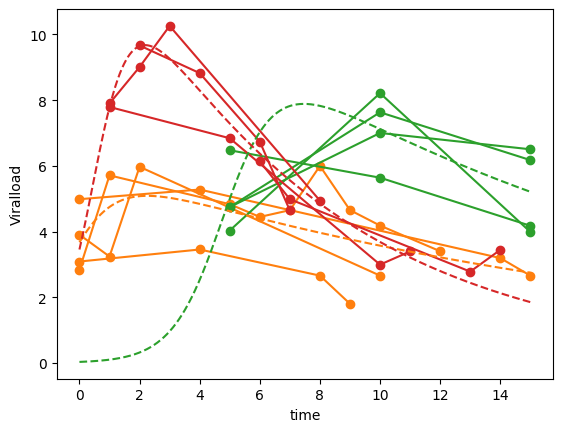

In [ ]:
a_dis=[]
b_dis=[]
c_dis=[]
for idx in range(len(disease_time)):
  n_v, n_t = make_avg_data([idx])
  real_data = pd.DataFrame({'time': n_t, 'V': n_v})

  print('--------')
  a = print_model_error(optimized_params_1, optimized_initial_conditions_1, real_data, t_span, t_eval, 'params1')
  b = print_model_error(optimized_params_2, optimized_initial_conditions_2, real_data, t_span, t_eval, 'params2')
  c = print_model_error(optimized_params_3, optimized_initial_conditions_3, real_data, t_span, t_eval, 'params3')
  print('')
  if a == min(a,b,c):
    a_dis.append(idx)
  elif b == min(a,b,c):
    b_dis.append(idx)
  else:
    c_dis.append(idx)

for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C1')
for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C2')
for idx in c_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C3')

plt.plot(t_1,v_1,c='C1', linestyle='--')
plt.plot(t_2,v_2,c='C2', linestyle='--')
plt.plot(t_3,v_3,c='C3', linestyle='--')

plt.ylabel('Viralload')
plt.xlabel('time')

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [3.13280292 0.0033251  0.04921779]
최적화된 초기 조건: [  4.03583512 733.94571901]


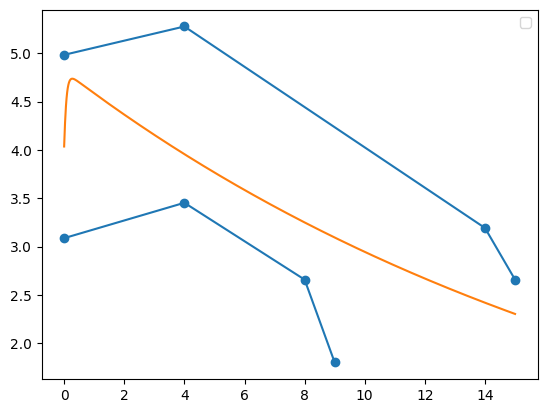

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_1) + [0.1, 3]

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(a_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_1, optimized_initial_conditions_1 = optimized_params, optimized_initial_conditions
t_1,v_1 = optimized_result['time'], optimized_result['V']

for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_1,v_1,'C1')
plt.legend()

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [ 3.19099975e-01  2.53494671e+00 -1.67174069e-03]
최적화된 초기 조건: [3.33612429 0.22915313]


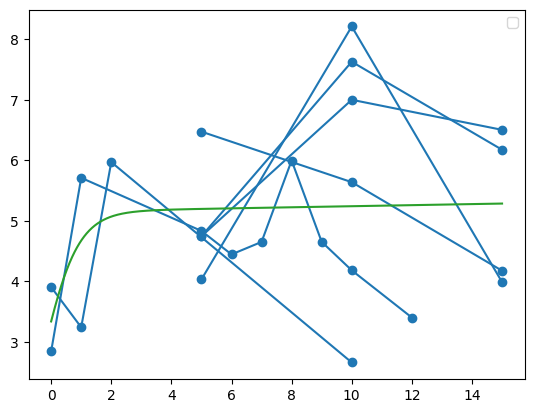

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_2) + [0.1, 3]

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(b_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_2, optimized_initial_conditions_2 = optimized_params, optimized_initial_conditions
t_2,v_2 = optimized_result['time'], optimized_result['V']

for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_2,v_2,'C2')
plt.legend()

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [0.48382023 1.95580549 0.11893532]
최적화된 초기 조건: [0.11964156 2.81076583]


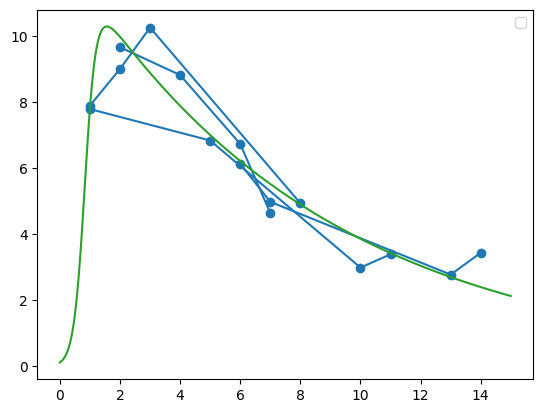

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_3) + [0.1, 3]

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(c_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_3, optimized_initial_conditions_3 = optimized_params, optimized_initial_conditions
t_3,v_3 = optimized_result['time'], optimized_result['V']

for idx in c_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_3,v_3,'C2')
plt.legend()

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


--------
params1의 오차 제곱합 (SSR): 3.177589207412754
params2의 오차 제곱합 (SSR): 21.427228804066438
params3의 오차 제곱합 (SSR): 40.06262477498747

--------
params1의 오차 제곱합 (SSR): 3.371445355644566
params2의 오차 제곱합 (SSR): 13.97345151024627
params3의 오차 제곱합 (SSR): 31.39311994772988

--------
params1의 오차 제곱합 (SSR): 4.489683573919285
params2의 오차 제곱합 (SSR): 9.864701414193433
params3의 오차 제곱합 (SSR): 52.91534474130865

--------
params1의 오차 제곱합 (SSR): 18.13344073684356
params2의 오차 제곱합 (SSR): 7.86487078992341
params3의 오차 제곱합 (SSR): 22.038081374652073

--------
params1의 오차 제곱합 (SSR): 37.902454718105155
params2의 오차 제곱합 (SSR): 6.702614670009803
params3의 오차 제곱합 (SSR): 35.62352770569893

--------
params1의 오차 제곱합 (SSR): 18.09346384476926
params2의 오차 제곱합 (SSR): 3.021961291690087
params3의 오차 제곱합 (SSR): 7.59927689699716

--------
params1의 오차 제곱합 (SSR): 35.060661276567046
params2의 오차 제곱합 (SSR): 4.78684453338086
params3의 오차 제곱합 (SSR): 34.05142428464377

--------
params1의 오차 제곱합 (SSR): 30.65928441461661
params2의 오차 제곱합 (S

Text(0.5, 0, 'time')

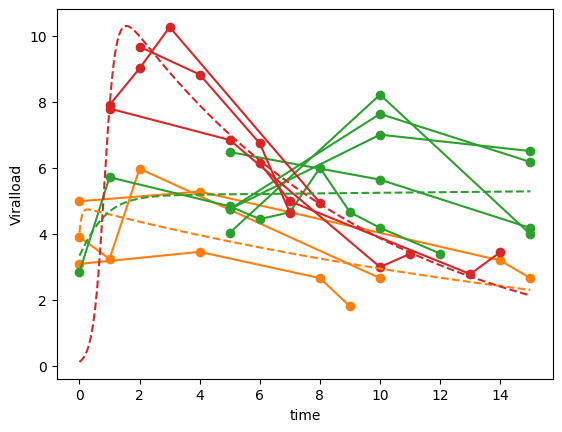

In [ ]:
a_dis=[]
b_dis=[]
c_dis=[]
for idx in range(len(disease_time)):
  n_v, n_t = make_avg_data([idx])
  real_data = pd.DataFrame({'time': n_t, 'V': n_v})

  print('--------')
  a = print_model_error(optimized_params_1, optimized_initial_conditions_1, real_data, t_span, t_eval, 'params1')
  b = print_model_error(optimized_params_2, optimized_initial_conditions_2, real_data, t_span, t_eval, 'params2')
  c = print_model_error(optimized_params_3, optimized_initial_conditions_3, real_data, t_span, t_eval, 'params3')
  print('')
  if a == min(a,b,c):
    a_dis.append(idx)
  elif b == min(a,b,c):
    b_dis.append(idx)
  else:
    c_dis.append(idx)

for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C1')
for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C2')
for idx in c_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C3')

plt.plot(t_1,v_1,c='C1', linestyle='--')
plt.plot(t_2,v_2,c='C2', linestyle='--')
plt.plot(t_3,v_3,c='C3', linestyle='--')

plt.ylabel('Viralload')
plt.xlabel('time')

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [1.45506579e+03 3.24979669e-01 4.95024601e-02]
최적화된 초기 조건: [   3.99197188 3726.82193365]


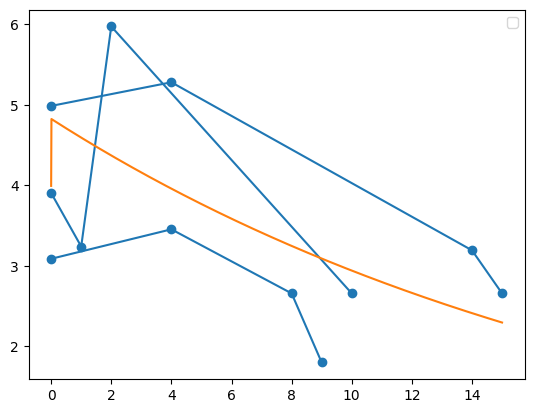

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_1) + [0.1, 3]

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(a_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_1, optimized_initial_conditions_1 = optimized_params, optimized_initial_conditions
t_1,v_1 = optimized_result['time'], optimized_result['V']

for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_1,v_1,'C1')
plt.legend()

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [ 4.68020100e+00  2.63733888e-01 -2.86307024e-03]
최적화된 초기 조건: [ 2.84136319 42.29230001]


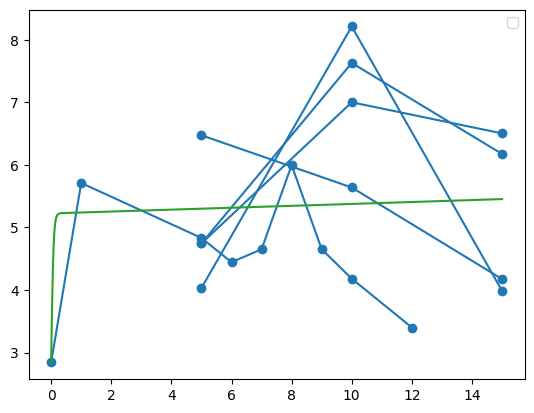

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_2) + [0.1, 3]

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(b_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_2, optimized_initial_conditions_2 = optimized_params, optimized_initial_conditions
t_2,v_2 = optimized_result['time'], optimized_result['V']

for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_2,v_2,'C2')
plt.legend()

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


최적화된 파라미터: [0.13689113 0.06563526 0.13764876]
최적화된 초기 조건: [ 3.45275712 19.78190261]


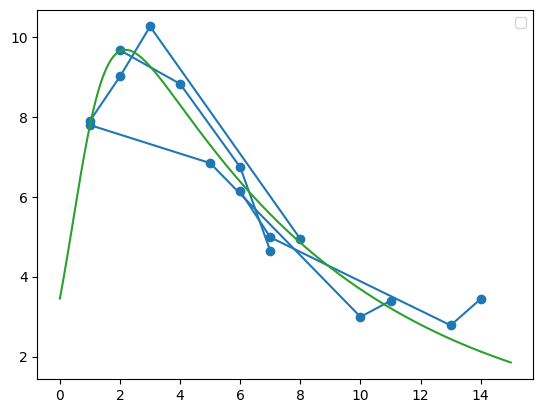

In [ ]:
# 파라미터와 초기 조건, boundary 설정
initial_guess = list(optimized_params_3) + [0.1, 3]

# 최적화 함수 실행 (비용 함수 최소화)
iteration_log = []
result = minimize(cost_function_list, initial_guess, args=(c_dis, t_span, t_eval, iteration_log), method='Nelder-Mead', bounds=bounds,options={'maxiter': 1500})

# 최적화된 파라미터 및 초기 조건 출력
optimized_params = result.x[:3]  # 최적화된 파라미터
optimized_initial_conditions = result.x[3:]  # 최적화된 초기 조건
print("최적화된 파라미터:", optimized_params)
print("최적화된 초기 조건:", optimized_initial_conditions)

# 최적화된 파라미터로 시뮬레이션 실행 및 결과 출력
optimized_result = simulate(optimized_params, optimized_initial_conditions, t_span, t_eval)
################################################################################
optimized_params_3, optimized_initial_conditions_3 = optimized_params, optimized_initial_conditions
t_3,v_3 = optimized_result['time'], optimized_result['V']

for idx in c_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C0')
plt.plot(t_3,v_3,'C2')
plt.legend()

<ipython-input-20-df5244c55a32>:18: RuntimeWarning: Mean of empty slice
  n_v = np.nanmean(np.vstack(data_array_list),axis=0)


--------
params1의 오차 제곱합 (SSR): 3.084567392504011
params2의 오차 제곱합 (SSR): 23.31472942124075
params3의 오차 제곱합 (SSR): 34.23976181386395

--------
params1의 오차 제곱합 (SSR): 3.4684088471639924
params2의 오차 제곱합 (SSR): 17.453122200033263
params3의 오차 제곱합 (SSR): 13.227376627120476

--------
params1의 오차 제곱합 (SSR): 4.479815735542351
params2의 오차 제곱합 (SSR): 13.03190056897441
params3의 오차 제곱합 (SSR): 35.41423665296908

--------
params1의 오차 제곱합 (SSR): 18.07196835778928
params2의 오차 제곱합 (SSR): 8.03958982672873
params3의 오차 제곱합 (SSR): 17.370649868069382

--------
params1의 오차 제곱합 (SSR): 37.994033683173924
params2의 오차 제곱합 (SSR): 5.908934101716476
params3의 오차 제곱합 (SSR): 40.75011673635804

--------
params1의 오차 제곱합 (SSR): 18.141946241818896
params2의 오차 제곱합 (SSR): 3.0830209582828028
params3의 오차 제곱합 (SSR): 9.892018633406511

--------
params1의 오차 제곱합 (SSR): 35.15121224491012
params2의 오차 제곱합 (SSR): 4.051985691337478
params3의 오차 제곱합 (SSR): 39.13374096463079

--------
params1의 오차 제곱합 (SSR): 30.726746554224434
params2의 오차 

Text(0.5, 0, 'time')

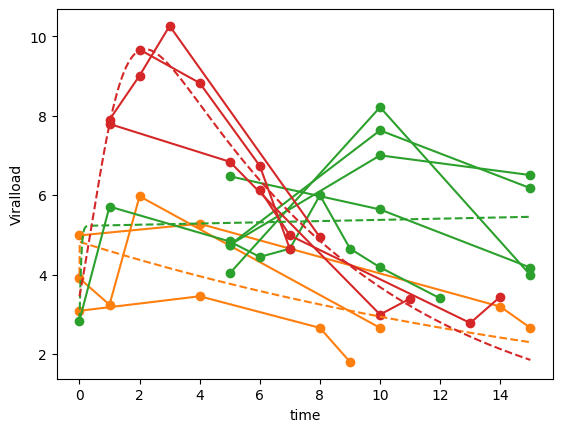

In [ ]:
a_dis=[]
b_dis=[]
c_dis=[]
for idx in range(len(disease_time)):
  n_v, n_t = make_avg_data([idx])
  real_data = pd.DataFrame({'time': n_t, 'V': n_v})

  print('--------')
  a = print_model_error(optimized_params_1, optimized_initial_conditions_1, real_data, t_span, t_eval, 'params1')
  b = print_model_error(optimized_params_2, optimized_initial_conditions_2, real_data, t_span, t_eval, 'params2')
  c = print_model_error(optimized_params_3, optimized_initial_conditions_3, real_data, t_span, t_eval, 'params3')
  print('')
  if a == min(a,b,c):
    a_dis.append(idx)
  elif b == min(a,b,c):
    b_dis.append(idx)
  else:
    c_dis.append(idx)

for idx in a_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C1')
for idx in b_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C2')
for idx in c_dis:
  plt.plot(disease_time[idx], disease_viralload[idx], 'o-', c='C3')

plt.plot(t_1,v_1,c='C1', linestyle='--')
plt.plot(t_2,v_2,c='C2', linestyle='--')
plt.plot(t_3,v_3,c='C3', linestyle='--')

plt.ylabel('Viralload')
plt.xlabel('time')